<a href="https://colab.research.google.com/github/simplaj/Rust-Learn/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=TimesFM+-+Time+Series+Foundation+Model.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FTimesFM%2520-%2520Time%2520Series%2520Foundation%2520Model.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

## TimesFM

TimesFM (Time Series Foundation Model) is a pretrained time-series foundation model developed by Google Research for time-series forecasting.

What does that mean? The training is completed, this is a model that has learned time series patterns and can do inference on input series to create forecasted horizons.  

This notebook based workflows shows how to get started directly in the notebook with:
- Setting up the enviornment:
    - This notebook in an environment - CPU method used here but GPU/TPU is available
    - The right Python version and packages - A Conda Enviornment file is provided by TimesFM
    - This notebook running with a kernel using the enviornment
- Getting Started
    - Setup the Model
    - Make Inference using `numpy` arrays
- BigQuery With Bigframes API
    - Prepare and make BigQuery table a local `pandas` dataframe
    - Use TimesFM to genereate horizon forecast for each times series
    - Plot history and horizon along with quantiles for predictions

Details:
- [Google Research Blog](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/)
- [GitHub repo](https://github.com/google-research/timesfm)
- [HuggingFace Model Card](https://huggingface.co/google/timesfm-1.0-200m)

## Setup

### Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [8]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [9]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Are you sure you wish to set property [core/project] to statmike-mlops-349915?

Do you want to continue (Y/n)?  Y

Updated property [core/project].
Colab authorized to GCP


### Clone The `TimesFM` Repository

In [1]:
import os, shutil, yaml, importlib, subprocess
from IPython.display import display, Markdown

In [3]:
DIR = 'temp/timesfm'

In [4]:
if not os.path.exists(DIR):
    os.makedirs(DIR)
else:
    shutil.rmtree(DIR)
!git clone https://github.com/google-research/timesfm.git $DIR

Cloning into 'temp/timesfm'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 173 (delta 85), reused 141 (delta 72), pack-reused 2
Receiving objects: 100% (173/173), 1.32 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [5]:
with open(f'{DIR}/environment_cpu.yml', 'r') as f:
    data = f.read()
Markdown(f"```yaml\n\n{data}\n```")

```yaml

name: tfm_env

channels:
  - conda-forge
  - defaults
  - anaconda
dependencies:
  - jupyterlab
  - pip
  - python=3.10
  - pip:
    - huggingface_hub[cli]
    - utilsforecast
    - praxis
    - paxml
    - jax[cpu]==0.4.26
    - einshape

```

### Prepare The Environment: Conda Setup

In [6]:
# check for conda
try:
    subprocess.run(["conda", "--version"], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    display(Markdown('**NOTE: Proceed with this section and setup a conda environment.**'))
except FileNotFoundError:
    display(Markdown('**NOTE: Conda is not installed in this environment, skip to the next section to use pip install rather than conda environments.**'))

**NOTE: Conda is not installed in this environment, skip to the next section to use pip install rather than conda environments.**

As shown above, TimeFM comes with environment files for conda envioronments.  Similarly, the requirments could be met in any Python setup by having the requested Python version and packages installed.

Notes on Conda Enviornments:
- [Vertex AI Workbench Instances](https://cloud.google.com/vertex-ai/docs/workbench/instances/introduction) use [conda enviornments](https://cloud.google.com/vertex-ai/docs/workbench/instances/add-environment).  These links show how to add an enviornment like using the provided files in the TimesFM repository.
- Otherwise, add conda to your enviornment quickly with [Miniconda](https://docs.anaconda.com/free/miniconda/)

The following section walks through the enviornment setup for Vertex AI Workbench Instances and would be similar for other conda based enviornments.


**Open A Terminal:**
- File > New > Terminal
- Follow the steps in the following sections

**Conda:** Create and Activate the Environment
- In the terminal run:
    - `conda env create --file=temp/timesfm/environment_cpu.yml`
    - `conda env list`
    - `conda activate tfm_env`
    
**Install:** `timesfm` from local clone
- Check where `pip` is working from, it should be the active conda environment
    - `which pip`
- Install the `timesfm` package from the local clone directory
    - `pip install -e temp/timesfm`
    
**Add A Kernel:** For the new Environment:
- Make the new enviornment a kernel for Jupyter notebooks to use
    - `DL_ANACONDA_ENV_HOME="${DL_ANACONDA_HOME}/envs/tfm_env"`
    - `python -m ipykernel install --prefix "${DL_ANACONDA_ENV_HOME}" --name tfm_env --display-name TimesFM`

**Change Kernel:**
- Kernel > Change Kernel
- Select Kernel > Pick TimesFM > Select

**Verify The Kernel** is `TimeFM` in the upper right:
- ![Screenshot 2024-05-25 10.59.53 AM.png](attachment:a271641a-f773-4dda-8127-b27b12fd3d31.png)

### Add Additional Packages: All environments

Envionments without conda need to install all the packages from the environments file.  All environments need to install additional packages.

Add packages based on the environment:

In [7]:
install = False
try: #conda
    subprocess.run(["conda", "--version"], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    which_pip = !which pip
    print('pip is: ', which_pip[0])
    if not importlib.util.find_spec('timesfm'):
        !pip install -e temp/timesfm -U -q
        install = True
    if not importlib.util.find_spec('bigframes'):
        !pip install bigframes -U -q
        install = True
except FileNotFoundError: # Not conda
    with open(f'{DIR}/environment_cpu.yml', 'r') as f:
        reqs = yaml.safe_load(f)
    for req in reqs['dependencies'][-1]['pip']:
        !pip install $req -U -q
    !pip install -e temp/timesfm -U -q
    !pip install bigframes -U -q
    install = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.5/772.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.8/419.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.8/686.8 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

#### Restart Kernel (If Installs Occured)

> Add blockquote



After a kernel restart the code submission can start with the next cell after this one.

In [10]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Get Started

Setup TimesFM and make an inference call like the official repositories first example:

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
import timesfm
import numpy as np
import bigframes.pandas as bpd
import pandas as pd
from matplotlib import pyplot as plt

try:
    from google.colab import auth
    bpd.options.bigquery.project = PROJECT_ID
    bpd.options.bigquery.location = 'US'
except Exception:
    pass

In [3]:
tfm = timesfm.TimesFm(
    context_len=320, # multiple of 32 (input_path_len) up to 512
    horizon_len=14, # anything but < context_len recommended
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # cpu or gpu or tpu
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.20 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.60 seconds.
Jitting decoding.
Jitted decoding in 45.49 seconds.


In [4]:
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
#forecast_input

In [5]:
frequency_input = [0, 1, 2]
frequency_input

[0, 1, 2]

In [6]:
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)
point_forecast

array([[ 0.98036265,  1.0065464 ,  0.97734976,  0.9273101 ,  0.8363604 ,
         0.71367764,  0.55153346,  0.36207095,  0.16936718, -0.03599859,
        -0.24321304, -0.44177842, -0.6304513 , -0.7869308 ],
       [ 0.97850287,  1.0148498 ,  1.034449  ,  1.0563511 ,  1.0543985 ,
         1.0205518 ,  0.98920697,  0.95338243,  0.9227392 ,  0.86757666,
         0.81656194,  0.75556785,  0.6789558 ,  0.5859826 ],
       [ 0.91031927,  0.93258786,  0.9457283 ,  0.9527973 ,  0.9608646 ,
         0.9583587 ,  0.97184324,  0.97845036,  0.98321855,  0.986327  ,
         0.98587453,  0.9529107 ,  0.95764846,  0.94581884]],
      dtype=float32)

In [7]:
type(tfm._model)

patched_decoder.PatchedTimeSeriesDecoder

In [8]:
type(tfm._train_state)

paxml.train_states.TrainState

## Time Series Data: BigQuery With BigFrames

Similar to the other workflows in this repository, [Applied Forecasting](./readme.md), the following pulls a sample of times series from the BigQuery Public Dataset `bigquery-public-data.new_york.citibike_trips`.  A set of bike stations near New York City Central Park.  The time series are for daily demand for bikes trips starting at each station.

In [9]:
ds = bpd.read_gbq(
"""
SELECT
    start_station_name,
    COUNT(*) as num_trips,
    EXTRACT(DATE FROM starttime) AS starttime
FROM bigquery-public-data.new_york.citibike_trips
WHERE start_station_name LIKE '%Central Park%'
GROUP BY start_station_name, starttime
"""
)

Forbidden: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/statmike-mlops-349915/jobs?prettyPrint=false: Access Denied: Project statmike-mlops-349915: User does not have bigquery.jobs.create permission in project statmike-mlops-349915.

Location: US
Job ID: e52e28ff-4777-4b05-b284-c4d6cd87ff31


In [35]:
df = pd.read_csv('timing.csv')

In [36]:
df.head()

,partner_id,cust_id,house_id,pick_order_id,order_id,create_time,ext_material_id,material_id,material_name,qty
0,Panasonic,PMFBJ,sxsdxnc,930000055243,300000184158,2022-04-07 16:12:45,NYV20153BE,170000024922,NYV20153BE,11.0
1,Panasonic,PMFBJ,sxsdxnc,930000056084,300000187600,2022-04-12 08:08:53,ES-DG-PXZS10348,170000115281,2022奕承Plus（白）350*800展板,500.0
2,Panasonic,PMFBJ,sxsdxnc,930000056084,300000187600,2022-04-12 08:08:53,ES-DG-PXZS10349,170000115280,2022奕承Plus（彩）350*800展板,500.0
3,Panasonic,PMFBJ,sxsdxnc,930000056291,300000187693,2022-04-13 08:06:22,ES-DG-PXZS10348,170000115281,2022奕承Plus（白）350*800展板,1.0
4,Panasonic,PMFBJ,sxsdxnc,930000056291,300000187693,2022-04-13 08:06:22,ES-DG-PXZS10349,170000115280,2022奕承Plus（彩）350*800展板,1.0


In [42]:
local_df = df
local_df['create_time'] = pd.to_datetime(local_df['create_time'])
local_df['create_time'] = pd.to_datetime(local_df['create_time'].dt.date)
local_df = local_df.groupby(['material_id', 'create_time'])['qty'].sum().reset_index()

In [48]:
local_df.head()

,material_id,create_time,qty
0,170000009185,2023-08-29,5.0
1,170000009190,2022-05-05,656.0
2,170000009190,2022-05-09,2608.0
3,170000009190,2022-05-10,1512.0
4,170000009190,2022-05-11,200.0


In [62]:
item_data = local_df[local_df['material_id']==170000009190]

In [63]:
# prompt: Using dataframe local_df: 补全日期范围内所有日期

start_date = item_data['create_time'].min()
end_date = item_data['create_time'].max()
date_range = pd.date_range(start=start_date, end=end_date)
item_data = item_data.set_index('create_time').reindex(date_range)
item_data['qty'] = item_data['qty'].fillna(0)
item_data['material_id'] = item_data['material_id'].fillna(item_data['material_id'][0])
item_data = item_data.reset_index()


<ipython-input-63-0ae9814018fe>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item_data['material_id'] = item_data['material_id'].fillna(item_data['material_id'][0])


In [64]:
item_data.head()

,index,material_id,qty
0,2022-05-05,1.700000e+11,656.0
1,2022-05-06,1.700000e+11,0.0
2,2022-05-07,1.700000e+11,0.0
3,2022-05-08,1.700000e+11,0.0
4,2022-05-09,1.700000e+11,2608.0


## TimeFM Forecasting

TimeFM has built in method, `.forecast_on_df` that takes input dataframes and creates forecast for each series.  The requirment for this input dataframe are:
- a date/time column named `ds`
- a time series name column named `unique_id`

The other inputs are:
- `freq` to indicate the frequency of the `ds` column
- `value_name` to indicate the column with the demand values for forecasting
- `num_jobs` to limit the number of series forecasted asynchronously.
    - -1 would detect the availabe cpus as the number of parallel operations
    - 1 would limit to synchronous processing
    
The resulting forcast contain the `unique_id` and `ds` columns with date for each horizon date/time indicated by the model setup above.  Additionally:
- `timesfm` has the forecasted demand
- each of the `times-fm-q-0.x` column has relative quantile for the forecasted demand: 0.1 to 0.9 in 0.1 increments where `times-fm-q-0.5` = `timesfm`

In [65]:
forecast_ds = tfm.forecast_on_df(
    inputs = item_data.rename(columns = {'material_id':'unique_id', 'index':'ds'}),
    freq = "D",
    value_name = 'qty',
    num_jobs = 1
).rename(columns = {'unique_id':'material_id', 'ds':'index'})

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [66]:
forecast_ds

,material_id,index,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1.700000e+11,2024-05-22,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,17.896238,109.264244
1,1.700000e+11,2024-05-23,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,17.262907,139.657639
2,1.700000e+11,2024-05-24,0.000000,0.0,0.0,0.0,0.0,0.000000,3.186536,6.477762,70.550583,196.516708
3,1.700000e+11,2024-05-25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,23.829882,66.150154,212.795715
4,1.700000e+11,2024-05-26,2.116047,0.0,0.0,0.0,0.0,2.116047,19.365252,35.241718,96.668762,241.837082
5,1.700000e+11,2024-05-27,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,32.759586,96.518776,217.687729
6,1.700000e+11,2024-05-28,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,19.486532,97.806023,229.227005
7,1.700000e+11,2024-05-29,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,5.551412,52.875942,199.715759
8,1.700000e+11,2024-05-30,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,10.514961,59.891579,209.752258
9,1.700000e+11,2024-05-31,10.255590,0.0,0.0,0.0,0.0,10.255590,21.055891,23.508747,80.204926,214.754395


material_id
1.700000e+11    Axes(0.125,0.11;0.775x0.77)
Name: timesfm, dtype: object

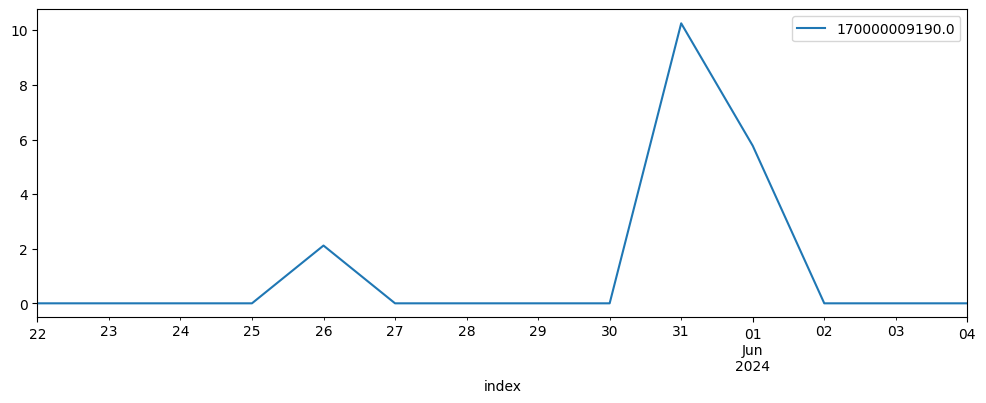

In [67]:
forecast_ds.set_index('index').groupby('material_id')['timesfm'].plot(legend = 'True', figsize = (12, 4))

## Visualize Time Series With Forecast And Quantiles

Plot each time series with the history, the forecast horzion, and quantile bands around the forecast for the horizon.

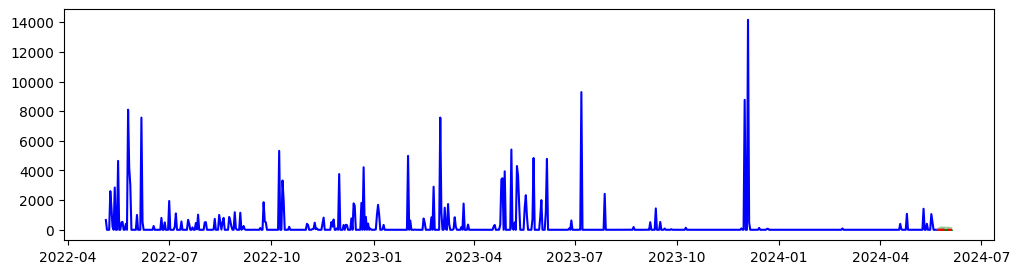

In [68]:
history = item_data.set_index('index')
horizon = forecast_ds.set_index('index')

plt.figure(figsize = (12,3))
plt.plot(history['qty'], linestyle = '-', color = 'blue')
plt.plot(horizon['timesfm'], linestyle = '--', color = 'red')
plt.fill_between(horizon.index, horizon['timesfm-q-0.4'], horizon['timesfm-q-0.6'], color = 'green', alpha = 1)
plt.fill_between(horizon.index, horizon['timesfm-q-0.3'], horizon['timesfm-q-0.7'], color = 'green', alpha = 0.75)
plt.fill_between(horizon.index, horizon['timesfm-q-0.2'], horizon['timesfm-q-0.8'], color = 'green', alpha = 0.5)
plt.fill_between(horizon.index, horizon['timesfm-q-0.1'], horizon['timesfm-q-0.9'], color = 'green', alpha = 0.25)
plt.show()